In [31]:
import requests
import datetime
import pandas as pd
import numpy as np
import re
import sys
import requests
import json
import time
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)    

from IPython.core.display import display, HTML
def display_side_by_side(dfs:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for df in dfs:
        output += df.style.set_table_attributes("style='max-width:100px;display:inline;'")._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

VTApiKey = "" 
BazaarApiKey = ""

# Studying Maicious Documents and Their Actions
___

By pulling from public sources such as MalwareBazaar and cross-referencing behavior data from VirusTotal, we can gather relevant information concerning how attackers utilizing malicious documents to drop and execute their payloads. Both MalwareBazaar and VirusTotal have free APIs that can be queried to gather the necessary information needed to create the tables and required metrics for building detections.

___
We can first begin by gathering hashes from MalwareBazaar, which have been tagged as ```docs```. In this case, we will collect 50 document reports and save them as a JSON object, and read them into a Pandas DataFrame 

___
_Note: The number of documents analyzed is arbitrary, but can go up to 1000 due to MalwareBazaar's report limit._

In [3]:
url = "https://mb-api.abuse.ch/api/v1/"
payload={'query': 'get_taginfo',
'tag': 'doc',
'limit': '50'}
files=[
]
headers = {
  'API-KEY': BazaarApiKey
}
response = requests.request("POST", url, headers=headers, data=payload, files=files)
if response.status_code == 200:
    print("MalwareBazaar data received")
else:
    print(str(response.status_code))
BazaarJsonobj = json.loads(response.text)

MalwareBazaar data received


___

Once receiving the document data, we will iterate through the list of returned hashes and request a behavior report from VirusTotal. Because of the query restrictions for free accounts on VirusTotal, a timer of 30 seconds is set to not cause problems for free VirusTotal API users. Fifty documents can be processed in VT in about 25 mins in this case. However, if an account has a higher threshold for queries, then that limiter can be removed.
___

In [7]:
payload={}
files=[
]
headers = {
  'x-apikey': VTApiKey
}
behavioursList = []
for i in BazaarJsonobj["data"]:
    response = requests.request("GET","https://www.virustotal.com/api/v3/files/{}/behaviours".format(i["sha256_hash"]),headers=headers, data=payload, files=files)
    if response.status_code == 200:
        behavioursList.append(json.loads(response.text))
        print(str(response.status_code) + " " + i["sha256_hash"])
        time.sleep(30)
    else: 
        print(str(response.status_code))
    
if len(behavioursList) > 1:
    print("\nAttributes in list")

200 2b596be066a85c5b338f606108824865ffb1c1d8400d488d45ba813da05ff02e
200 cd6eab2fafb7b32ebb1b9da555ba9a9a2276df141349a60598cd6d3f93180342
200 0b88e7d5c78fcc10a17d5e3a64ae52e48ae0a4e04001d3eb918ef628c0248949
200 769c2ffed446d6b8e9d501a8b37770c4041aa6536bb40c74cc99591073413fa3
200 7872305aab420a758b74bad9b7aa6d81fdc40cf3f5b744edcdc643da94296a2b
200 635624028186b883be0794d4f5e929de60cb87fdf9ec488a0718d43fbc2ec6bb
200 98a6fcee3ad612fea16011a69fb5945cbbb4ee0926b226b24dc645792943291a
200 006e2299ffc489d0feaec733040d21c2a0641e194243be416b0c018e1c1f2af3
200 69409736df3c6c36e70d30570ba872c0a76795cd5cad0e22c874138540db1281
200 8b1d9e9bab7ec0a06444fecb7f6ee047226c5478413c28e7b308a33e2b87d6bc
200 d09784d5888a8d83df084396e1df55f17ed55351fc4eda2f550c06ba66d191b0
200 ff3bff91899e431b92a5c69471d46983e7b7ac2b7c52ff36b983d5041393efd3
200 ef9ce000152d2e164a2ad8b13e427d95c8bf6570f244d837ac969c1548f41e71
200 822290021a83dff554d54852c8f487fcd466198a09ec0f96be2200e639d07dd9
200 1d69982a9173f3c9a513fb6fce37ef

___

One issue that will commonly come up as data is gathered from VirusTotal is the heterogeneous manner in which it is presented. Some data will return the absolute path, while others will present data as environment variables. In this case, we need the absolute path for data to be processed correctly. So we will create several regular expressions to find and replace the non-uniform data. 

The data we are interested in is:
- What data was written to disk?
- What, if any, processes were created?

With this, we can start setting up the DataFrames used later to present the data.
___

In [8]:
DroppedFiles = []
CommandExecutions = []
CommandDict = {}
for i in behavioursList:
    for j in i["data"]:
        if "files_dropped" in j["attributes"]:
            for k in j["attributes"]["files_dropped"]:
                x = re.search("^\/", k["path"])
                if x:
                   pass
                else:
                    translated = ""
                    if re.search(r"%APPDATA%", k["path"]):
                        translated = re.sub(r"%APPDATA%",r"c:\\users\\infected\\AppData\\Roaming", k["path"])
                    elif re.search(r"%LOCALAPPDATA%",k["path"]):
                        translated = re.sub(r"%LOCALAPPDATA%",r"c:\\users\\infected\\AppData\\Local", k["path"])
                    elif re.search(r"%HOMEPATH%",k["path"]):
                        ranslated = re.sub(r"%HOMEPATH%",r"c:\\users\\infected", k["path"])
                    elif re.search(r"%TEMP%", k["path"]):
                        translated = re.sub(r"%TEMP%",r"c:\\windows\\temp", k["path"])
                    elif re.search(r"%ALLUSERSPROFILE%", k["path"]):
                        translated = re.sub(r"%ALLUSERSPROFILE%",r"c:\\programdata", k["path"])
                    elif re.search(r"<SYSTEM32>", k["path"]):
                        translated = re.sub(r"<SYSTEM32>",r"c:\\windows\\system32", k["path"])
                    elif re.search(r"(%windir%|%WINDIR%)", k["path"]):
                        translated = re.sub(r"(%windir%|%WINDIR%)",r"c:\\windows", k["path"])
                    elif re.search(r"<USER>", k["path"]):
                        translated = re.sub(r"<USER>",r"infected", k["path"])
                    elif re.search(r"<DRIVERS>", k["path"]):
                        translated = re.sub(r"<DRIVERS>",r"c:\\windows\\system32\\Drivers", k["path"])
                    elif re.search(r"^C:\\", k["path"]) != True:
                        pass
                    elif re.search(r"(<CURRENT_DIR>|<PATH_SAMPLE>)", k["path"]):
                        pass              
                    else:
                        DroppedFiles.append(k["path"])
                    if translated != "":
                        DroppedFiles.append(translated.lower())
            if "files_written" in j["attributes"]:
                for k in j["attributes"]["files_written"]:
                    x = re.search("^\/", k)
                    if x:
                       pass
                    else:
                        translated = ""
                        if re.search(r"%APPDATA%", k):
                            translated = re.sub(r"%APPDATA%",r"c:\\users\\infected\\AppData\\Roaming", k)
                        elif re.search(r"%LOCALAPPDATA%",k):
                            translated = re.sub(r"%LOCALAPPDATA%",r"c:\\users\\infected\\AppData\\Local", k)
                        elif re.search(r"%HOMEPATH%",k):
                            ranslated = re.sub(r"%HOMEPATH%",r"c:\\users\\infected", k)
                        elif re.search(r"%TEMP%", k):
                            translated = re.sub(r"%TEMP%",r"c:\\windows\\temp", k)
                        elif re.search(r"%ALLUSERSPROFILE%", k):
                            translated = re.sub(r"%ALLUSERSPROFILE%",r"c:\\programdata", k)
                        elif re.search(r"<SYSTEM32>", k):
                            translated = re.sub(r"<SYSTEM32>",r"c:\\windows\\system32", k)
                        elif re.search(r"(%windir%|%WINDIR%)", k):
                            translated = re.sub(r"(%windir%|%WINDIR%)",r"c:\\windows", k)
                        elif re.search(r"<USER>", k):
                            translated = re.sub(r"<USER>",r"infected", k)
                        elif re.search(r"<DRIVERS>", k):
                            translated = re.sub(r"<DRIVERS>",r"c:\\windows\\system32\\Drivers", k)
                        elif re.search(r"^C:\\", k) != True:
                            pass
                        elif re.search(r"(<CURRENT_DIR>|<PATH_SAMPLE>)", k):
                            pass              
                        else:
                            DroppedFiles.append(k)
                        if translated != "":
                            DroppedFiles.append(translated.lower())
                            
DroppedFiles = list(dict.fromkeys(DroppedFiles)) #Remove Duplicates
FilesWritten = pd.DataFrame({"Files Written":DroppedFiles})

___

We can also look at the command lines to determine what processes were launched by the malicious document. In this case, we take the same data set and iterate through all of the process executions, and put the data into a DataFrame for viewing.
___


In [9]:
CommandLines = []
for i in behavioursList:
    for j in i["data"]:
        if "command_executions" in j["attributes"]:
            for k in j["attributes"]["command_executions"]:
                x = re.search("\(.*\.exe\)", k)
                z = re.search("(?<=commandline:)",k)
                if x:
                    split = re.split(r"(?<=\))\s",k)
                    CommandLines.append(split[1])
                    #print(f"{split[1]}")
                elif z:
                    split = re.split(r"(?<=commandline:)\s",k)
                    CommandLines.append(split[1])
                else:
                    CommandLines.append(k)
                    
    for j in i["data"]:
        if "processes_created" in j["attributes"]:
            for k in j["attributes"]["processes_created"]:
                x = re.search("\(.*\.exe\)", k)
                z = re.search("(?<=commandline:)",k)
                if x:
                    split = re.split(r"(?<=\))\s",k)
                    CommandLines.append(split[1])
                    #print(f"{split[1]}")
                elif z:
                    split = re.split(r"(?<=commandline:)\s",k)
                    CommandLines.append(split[1])
                else:
                    CommandLines.append(k)

CommandLinesBuffer = []                    
for i in CommandLines:
    x = re.search("^\/", i)
    if x:
       pass
    else:
        translated = ""
        if re.search(r"%APPDATA%", i):
            translated = re.sub(r"%APPDATA%",r"c:\\users\\infected\\AppData\\Roaming", i)
        elif re.search(r"%LOCALAPPDATA%",i):
            translated = re.sub(r"%LOCALAPPDATA%",r"c:\\users\\infected\\AppData\\Local", i)
        elif re.search(r"%HOMEPATH%",i):
            ranslated = re.sub(r"%HOMEPATH%",r"c:\\users\\infected", i)
        elif re.search(r"%TEMP%", i):
            translated = re.sub(r"%TEMP%",r"c:\\windows\\temp", i)
        elif re.search(r"%ALLUSERSPROFILE%", i):
            translated = re.sub(r"%ALLUSERSPROFILE%",r"c:\\programdata", i)
        elif re.search(r"<SYSTEM32>", i):
            translated = re.sub(r"<SYSTEM32>",r"c:\\windows\\system32", i)
        elif re.search(r"(%windir%|%WINDIR%)", i):
            translated = re.sub(r"(%windir%|%WINDIR%)",r"c:\\windows", i)
        elif re.search(r"<USER>", i):
            translated = re.sub(r"<USER>",r"infected", i)
        elif re.search(r"users\\(xxx|lucas|user)", i.lower()):
            translated = re.sub(r"users\\(xxx|lucas|user)",r"users\\infected", i.lower())
        elif re.search(r"<DRIVERS>", i):
            translated = re.sub(r"<DRIVERS>",r"c:\\windows\\system32\\Drivers",i)
        elif re.search(r"(<CURRENT_DIR>|<PATH_SAMPLE>)", i):
            pass    
        elif re.search(r"conhost", i.lower()):
            pass 
        else:
            CommandLinesBuffer.append(i.lower())
        if translated != "":
            CommandLinesBuffer.append(translated.lower())
            
CommandLinesBuffer = list(dict.fromkeys(CommandLinesBuffer))
CommandLines = CommandLinesBuffer
CommandLinesDF = pd.DataFrame({"Command Lines":CommandLines})

___

Using Regular Expressions, we can match on directories of interest to prioritize what to build detections on as well as look at what extensions that should be included to cut down on the number of false positives.
___

In [53]:
System32Count = 0
TempCount = 0
AppdataCount = 0
ProgramdataCount = 0
PublicCount = 0
EverythingElseCount = 0

System32List = []
TempList = []
AppdataList = []
ProgramdataList = []
PublicList = []
EverythingElseList = []

for i in DroppedFiles:
        if re.search(r"c:\\windows\\system32", i):
            if re.search(r"(hosts)", i):
                pass
            else:
                System32Count+=1
                System32List.append(i)
        elif re.search(r"c:\\windows\\temp", i):
            TempCount+=1
            TempList.append(i)
        elif re.search(r"c:\\users\\infected\\appdata", i):
            if re.search(r"\bmicrosoft\b", i):
                pass
            else:
                AppdataCount+=1
                AppdataList.append(i)
        elif re.search(r"c:\\programdata", i):
            if re.search(r"(\.vsch|\.vpol)", i):
                pass
            else:
                ProgramdataCount+=1
                ProgramdataList.append(i)
        elif re.search(r"c:\\users\\public", i):
            PublicCount += 1
            PublicList.append(i)
        else: 
            EverythingElseCount += 1
            EverythingElseList.append(i)
            
PathBarList = [System32Count,TempCount, AppdataCount,ProgramdataCount, PublicCount, EverythingElseCount]
PathMetrics = pd.DataFrame(
    {
        "System32":[System32Count],
        "Windows\\Temp":[TempCount],
        "Appdata":[AppdataCount],
        "ProgramData":[ProgramdataCount],
        "Public":[PublicCount],
        "EverythingElse":[EverythingElseCount]
    },
    index=["Count"]
)

System32DF = pd.DataFrame(
    {
        "System32":System32List    
    }
)

TempDF = pd.DataFrame(
    {
        "Windows\\Temp":TempList   
    }
)
AppDataDF = pd.DataFrame(
    {
        "Appdata":AppdataList   
    }
)
ProgramdataDF = pd.DataFrame(
    {
        "ProgramData":ProgramdataList  
    }
)
PublicDF = pd.DataFrame(
    {
        "Public":PublicList    
    }
)
EverythingElseDF = pd.DataFrame(
    {
        "Everything Else":EverythingElseList    
    }
)

In [54]:
ExeAtAtRootCount_Roaming = 0
ExeAtAtRootCount_Local = 0
ExeAtAtRootCount_LocalLow = 0 
ExeAtAtRootCount_LocalTemp = 0

ExeInSubDir_Roaming = 0
ExeInSubDir_Local = 0
ExeInSubDir_LocalTemp = 0 
ExeInSubDir_LocalLow = 0
for i in DroppedFiles:
    if re.search(r"microsoft", i):
        pass
    else:
        if re.search(r"c:\\users\\infected\\appdata\\roaming", i):
            if re.search(r"c:\\users\\infected\\appdata\\roaming\\\w*\.exe", i):
                ExeAtAtRootCount_Roaming+=1
            else:
                ExeInSubDir_Roaming += 1
        elif re.search(r"c:\\users\\infected\\appdata\\local\\temp", i):
            if re.search(r"c:\\users\\infected\\appdata\\local\\temp\\\w*\.exe", i):
                ExeAtAtRootCount_LocalTemp += 1
            else:
                ExeInSubDir_LocalTemp += 1
        elif re.search(r"c:\\users\\infected\\appdata\\local", i):
            if re.search(r"c:\\users\\infected\\appdata\\local\\\w*\.exe", i):
                ExeAtAtRootCount_Local+=1
            else:
                ExeInSubDir_Local += 1
        elif re.search(r"c:\\users\\infected\\appdata\\locallow", i):
            if re.search(r"c:\\users\\infected\\appdata\\locallow\\\w*\.exe", i):
                ExeAtAtRootCount_LocalLow += 1
            else:
                ExeInSubDir_LocalLow += 1
            
DFContents = [
    [ExeAtAtRootCount_Roaming,ExeAtAtRootCount_Local,ExeAtAtRootCount_LocalLow,ExeAtAtRootCount_LocalTemp],
    [ExeInSubDir_Roaming,ExeInSubDir_LocalTemp,ExeInSubDir_Local,ExeInSubDir_LocalLow]
]           
AppdataBreakdownDF = pd.DataFrame(DFContents,index=["Exe At Root","Exe in Subdirectory"],columns=["AppData\\Roaming","AppData\\Local","AppData\\LocalLow","AppData\\Local\\Temp"])

## Counts for file writes to directories of interest

In [12]:
display_side_by_side([PathMetrics.head(50),AppdataBreakdownDF.head(50)])

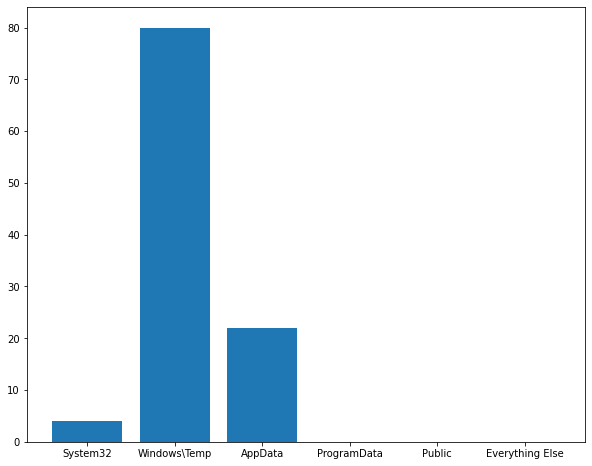

In [57]:
figure( figsize=(10, 8))
plt.bar(["System32","Windows\\Temp","AppData","ProgramData","Public","Everything Else"], PathBarList)
plt.show()

## Sample set of files written to ProgamData, Windows\\System32, and other misc locations

In [13]:
display_side_by_side([ProgramdataDF.head(50),EverythingElseDF.head(50),System32DF.head(50)])

,ProgramData
,Everything Else
,System32
0,c:\windows\system32\tasks\updates\ixqbqkbla
1,c:\windows\system32\tasks\updates\wbicishptc
2,c:\windows\system32\tasks\updates\xvphzzzbcdrtxb
3,c:\windows\system32\tasks\updates\zgktfv


## Sample Set of files written to Users\\Public, Users\\infected\\AppData, and Windows\\Temp

In [14]:
display_side_by_side([PublicDF.head(50),AppDataDF.head(50),TempDF.head(50)])

,Public
,Appdata
0,c:\users\infected\appdata\roaming\kat.exe
1,c:\users\infected\appdata\roaming\ixqbqkbla.exe
2,c:\users\infected\appdata\roaming\kill.exe
3,c:\users\infected\appdata\roaming\wbicishptc.exe
4,c:\users\infected\appdata\roaming\xvphzzzbcdrtxb.exe
5,c:\users\infected\appdata\roaming\obi.exe
6,c:\users\infected\appdata\roaming\zgktfv.exe
7,c:\users\infected\appdata\roaming\ikeji347618.exe
8,c:\users\infected\appdata\roaming\lgwealth839.exe


## Parsing children of the malicious document

In [45]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
WinWordCount = 0
System32Count = 0
AppdataCount = 0
EverythingElseCount =0
SysWow64Count=0
ProgramFilesCount=0
ProgramdataCount = 0            

WinWordList = []
System32List = []
AppdataList = []
EverythingElseList = []
SysWow64List = []
ProgramFilesList = []
ProgramdataList = []

for i in CommandLines:
    i=i.lower()
    if re.search(r"winword", i):
            WinWordCount+=1
            WinWordList.append(i)
    elif re.search(r"c:\\windows\\system32", i):
            System32Count += 1
            System32List.append(i)
    elif re.search(r"appdata", i):
            AppdataCount+=1
            AppdataList.append(i)
    elif re.search(r"c:\\windows\\syswow64", i):
            SysWow64Count+=1
            SysWow64List.append(i)
    elif re.search(r"(program files|%commpnprogramfiles%)", i):
            ProgramFilesCount+=1
            ProgramFilesList.append(i)
    elif re.search(r"programdata", i):
            ProgramdataCount+=1
            ProgramdataList.append(i)
    else:
        EverythingElseCount += 1
        EverythingElseList.append(i)

CommandBreakdownDF = pd.DataFrame(
    {
        "Winword":[WinWordCount],
        "System32":[System32Count],
        "Appdata":[AppdataCount],
        "SysWOW64":[SysWow64Count],
        "ProgramFiles":[ProgramFilesCount],
        "Programdata":[ProgramdataCount],
        "Everything Else":[EverythingElseCount]
    },
    index=["Count"]
)
BarList = [WinWordCount,System32Count,AppdataCount,SysWow64Count,ProgramFilesCount,ProgramdataCount,EverythingElseCount]
SizeOfCommandsList = pd.DataFrame(
    {
    "Number of Commands":[len(CommandLines)]
    },
    index=["Count"]
)

WinWordExecDF = pd.DataFrame(
    {
        "Winword":WinWordList   
    }
)
System32ExecDF = pd.DataFrame(
    {
        "System32":System32List   
    }
)
AppDataExecDF = pd.DataFrame(
    {
        "AppData":AppdataList  
    }
)
ProgramFilesExecDF = pd.DataFrame(
    {
        "Program Files":ProgramFilesList  
    }
)
SysWOW64DF = pd.DataFrame(
    {
        "AppData":SysWow64List  
    }
)
ProgramDataExecDF = pd.DataFrame(
    {
        "Everything Else":ProgramdataList    
    }
)
EverythingElseExecDF = pd.DataFrame(
    {
        "Everything Else":EverythingElseList    
    }
)

## Size of CommandLines list

In [46]:
SizeOfCommandsList

,Number of Commands
Count,218


## Counts for command execution locations

In [47]:
CommandBreakdownDF

,Winword,System32,Appdata,SysWOW64,ProgramFiles,Programdata,Everything Else
Count,80,24,34,31,7,9,33


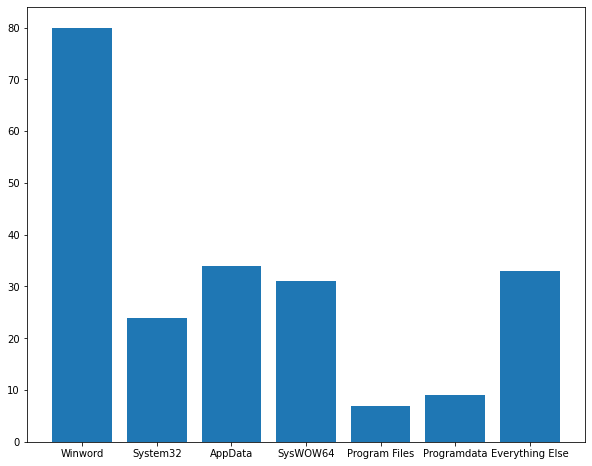

In [48]:
figure( figsize=(10, 8))
plt.bar(["Winword","System32","AppData","SysWOW64","Program Files","Programdata","Everything Else"], BarList)
plt.show()

## Command executions for or by Winword

In [38]:
WinWordExecDF

,Winword
0,"""c:\program files (x86)\microsoft office\office14\winword.exe"" invoice.doc.rtf"
1,c:\program files (x86)\microsoft office\office14\winword.exe
2,c:\program files (x86)\microsoft office\office12\winword.exe /automation -embedding
3,bin\is32bit.exe -f c:\program files (x86)\microsoft office\office15\winword.exe
4,bin\zhjduzarj.exe --app c:\program files (x86)\microsoft office\office15\winword.exe --only-start --args c:\users\a4148~1.mon\appdata\local\temp\5f5f34af3d6627f5fe9f67de3ed6bfd6.doc /e --curdir c:\users\a4148~1.mon\appdata\local\temp
5,c:\program files (x86)\microsoft office\office15\winword.exe c:\users\a4148~1.mon\appdata\local\temp\5f5f34af3d6627f5fe9f67de3ed6bfd6.doc /e
6,bin\cnkufvmsw.exe --app c:\program files (x86)\microsoft office\office15\winword.exe --only-start --args c:\users\a4148~1.mon\appdata\local\temp\0ff0a971e636ef79eadd6db404752a04.doc /e --curdir c:\users\a4148~1.mon\appdata\local\temp
7,c:\program files (x86)\microsoft office\office15\winword.exe c:\users\a4148~1.mon\appdata\local\temp\0ff0a971e636ef79eadd6db404752a04.doc /e
8,"""c:\program files (x86)\microsoft office\office14\winword.exe"" egsiv@_inen_2.15_01_20210422.doc.rtf"
9,"""c:\program files (x86)\microsoft office\office14\winword.exe"" /t /q c:\users\infected\documents\144b195bfa3deea54e133c06eb3088nalysis_subject.rtf"


## Sample set for misc. command executions

In [49]:
EverythingElseExecDF.head(50)

,Everything Else
0,c:\windows\splwow64.exe 12288
1,{path}
2,c:\windows\splwow64.exe
3,bin\is32bit.exe -p 1228
4,bin\cgsesqpzkgvxr.exe /terminate
5,bin\is32bit.exe -p 2800
6,c:\windows\microsoft.net\framework\v4.0.30319\mscorsvw.exe
7,c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe
8,c:\windows\splwow64.exe 8192
9,timeout 1
